In [1]:
""" Initial exploration of fitbit heart rate data """

import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")


In [2]:
# Load data

fn = '/Users/kmcmanus/Documents/classes/digitalhealth_project/data/data_dump/user-site-export/heart_rate-2020-01-13.json'
with open(fn) as f:
  whyred = json.load(f)
whyred[0:5]

[{'dateTime': '01/13/20 08:00:07', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:22', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:37', 'value': {'bpm': 59, 'confidence': 3}},
 {'dateTime': '01/13/20 08:00:52', 'value': {'bpm': 60, 'confidence': 3}},
 {'dateTime': '01/13/20 08:01:07', 'value': {'bpm': 60, 'confidence': 3}}]

In [3]:
# Convert to dataframe
index = pd.to_datetime([x['dateTime'] for x in whyred])
data = [[x['value']['bpm'], x['value']['confidence']] for x in whyred]

df = pd.DataFrame(data, index=index, columns=['bpm', 'confidence'])
df.head()

,bpm,confidence
2020-01-13 08:00:07,59,3
2020-01-13 08:00:22,59,3
2020-01-13 08:00:37,59,3
2020-01-13 08:00:52,60,3
2020-01-13 08:01:07,60,3


In [4]:
df.shape

(10508, 2)

Text(0.5, 1.0, 'Distribution of heart rate over one day (2019-01-12)')

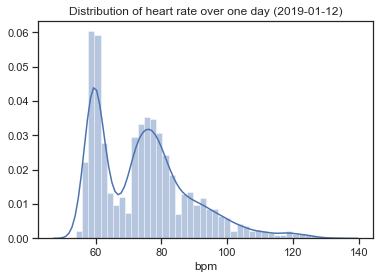

In [5]:
ax = sns.distplot(df["bpm"])
ax.set_title("Distribution of heart rate over one day (2019-01-12)")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Heart rate over one day (2019-01-13)')

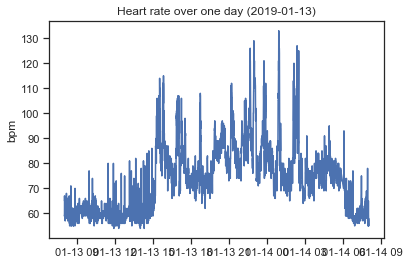

In [6]:
ax = sns.lineplot(x=df.index, y=df["bpm"])
ax.set_title("Heart rate over one day (2019-01-13)")

In [7]:
# Ok let's predict resting vs. sleeping with a tensorflow HMM.
# Interestingly, tensorflow has HMMs implemented, assuming you already know the parameters
# But doesn't have methods implemented to infer parameters

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

initial_distribution = tfd.Categorical(probs=[0.66, 0.33])

transition_distribution = tfd.Categorical(probs=[[0.9, 0.1],
                                                 [0.1, 0.9]])

observation_distribution = tfd.Normal(loc=[63., 80.], scale=[3., 10.])

model = tfd.HiddenMarkovModel(
      initial_distribution=initial_distribution,
      transition_distribution=transition_distribution,
      observation_distribution=observation_distribution,
      num_steps=10508)

print(model.mean())

print(model.log_prob(tf.zeros(shape=[7])))
print(model)

tf.Tensor([68.666664 69.23333  69.68666  ... 71.49977  71.49977  71.49977 ], shape=(10508,), dtype=float32)
tf.Tensor(-248.18616, shape=(), dtype=float32)
tfp.distributions.HiddenMarkovModel("HiddenMarkovModel", batch_shape=[], event_shape=[10508], dtype=float32)


In [8]:
df["bpm"] = df["bpm"].astype(np.float32)
result = model.posterior_mode(df["bpm"])

In [9]:
(unique, counts) = np.unique(result.numpy(), return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 3933],
       [   1, 6575]])

In [10]:
# Add result to bpm
df["state"] = result.numpy()
df["datetime"] = df.index
df.head()

,bpm,confidence,state,datetime
2020-01-13 08:00:07,59.0,3,0,2020-01-13 08:00:07
2020-01-13 08:00:22,59.0,3,0,2020-01-13 08:00:22
2020-01-13 08:00:37,59.0,3,0,2020-01-13 08:00:37
2020-01-13 08:00:52,60.0,3,0,2020-01-13 08:00:52
2020-01-13 08:01:07,60.0,3,0,2020-01-13 08:01:07


Text(0.5, 0, 'Time')

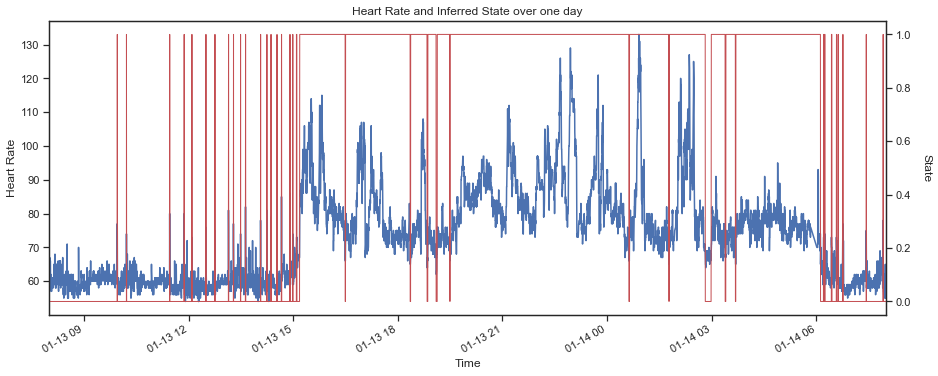

In [11]:
ax = df.plot(x="datetime", y="bpm", legend=False, figsize=(15, 6))
ax2 = ax.twinx()
df.plot(x="datetime", y="state", ax=ax2, linewidth=1, legend=False, color="r")
plt.title("Heart Rate and Inferred State over one day")
ax.set_ylabel("Heart Rate")
ax2.set_ylabel("State", rotation=270, labelpad=20)
ax.set_xlabel("Time")

In [12]:
# Load what fitbit says about my sleep
# fn = '/Users/kmcmanus/Documents/classes/algorithm_practice/fitbit_projects/data/data_dump/user-site-export/sleep-2020-01-11.json'
# with open(fn) as f:
#   fitbit_sleep_all = json.load(f)
# fitbit_sleep = [x for x in fitbit_sleep_all if x['dateOfSleep'] == "2020-01-14"]
# fitbit_sleep

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kmcmanus/Documents/classes/algorithm_practice/fitbit_projects/data/data_dump/user-site-export/sleep-2020-01-11.json'

In [ ]:
# We can see a few problems with this model.
# The primary one is that it thinks I am sleeping at random points during the day.
# I never nap, so this is clearly not what is happening.
# I realize this is probably why fitbit requires "3 hours" of data
# before they decide to report on your sleep. They are looking for a consistent 3 hour signal.